# Timeseries Prediction

Topics:

* Nature of prediction models of **DynamicalSystems.jl**
* Local model prediction
* Multi-variate local model Prediction


## Nature of prediction models
Suppose you have a scalar or multi-variate timeseries and you want to predict its future behaviour.

You can either take your *neural-network/machine-learning hammer* and lots of computing power **or** you can use methods from nonlinear dynamics and chaos.

**DynamicalSystems.jl** follows the second approach. This road is not only surprisingly powerful, but also much, **much** simpler.

---

# Local Model Prediction

Local model prediction does something very simple: it makes a prediction of a state, by finding the future of similar (*neighboring*) states! Then it uses the predicted state as a new state from which other predictions can be made!

Yeap, that simple.

Let's see how well this method fares in a simple system, the Roessler system (3D & chaotic):

$$
\begin{aligned}
\dot{x} &= -y-z \\
\dot{y} &= x+ay \\
\dot{z} &= b + z(x-c)
\end{aligned}
$$

In [1]:
using DynamicalSystems 

# This initial condition gives a good prediction:
u0_good = [0.065081, 0.917503, 0.300242]

ross = Systems.roessler(u0_good)

3-dimensional continuous dynamical system
 state:       [0.065081, 0.917503, 0.300242]
 e.o.m.:      roessler_eom
 in-place?    false
 jacobian:    roessler_jacob
 parameters:  [0.2, 0.2, 5.7]

Let's get a "measurement" from the roessler system

In [24]:
dt = 0.1 # sampling rate
tf = 1000.0 # final time
tr = trajectory(ross, tf; dt = dt)

# This is the measurement
s = tr[50:end, 2] # we skip the first points, they are transient
# This is the accompanying time vector:
timevec = collect(0:dt:tf)[50:end];

How does this timeseries look?

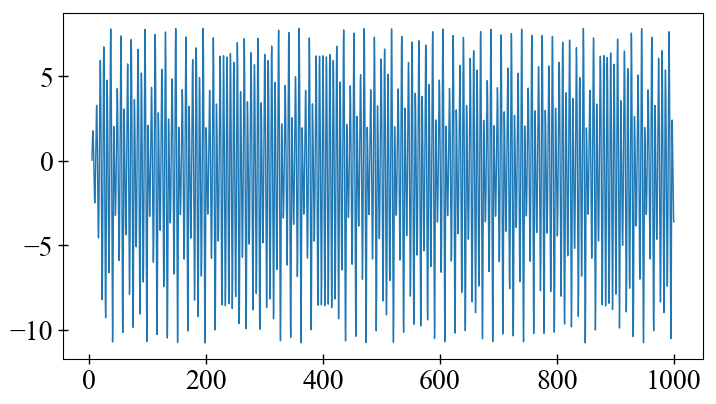

In [3]:
using PyPlot; figure(figsize = (8,4))
plot(timevec, s, lw = 1.0);

Please note: these are chaotic oscillations, the system is *not* periodic for the chosen (default) parameter values!

Alright, so we have a recorded some timeseries of length:

In [4]:
length(s)

9952

And now we want to predict!

Let's see the prediction function in action! The function to use is
```julia
localmodel_tsp(s, D::Int, τ, p::Int; kwargs...)
```
Here `s` is the timeseries to be predicted. `D, τ` are the values of the `Reconstruction` that has to be made from `s`. The last argument `p` is simply the amount of points to predict!

The `Reconstruction` idea and functions were introduced in the tutorial "Delay Coordinates Embedding". 

This local model prediction method assumes that the system is on some kind of chaotic attractor. This is why it is crucial to reconstruct a signal before using the method!

Let's use only a first part of the timeseries as a "training set"

In [25]:
N = length(s)
N_train = 1000
s_train = s[1:N_train];

and then use the rest of the timeseries to compare with the prediction

In [26]:
s_test = s[N_train+1:end];

Here we define the parameters to make a prediction:

In [27]:
using TimeseriesPrediction
τ = 17
D = 2
p = 500

s_pred = localmodel_tsp(s_train, D, τ, p)
# prediction always includes last point of `s_train`

501-element Array{Float64,1}:
 -1.0124397170690507 
 -0.6185133949265879 
 -0.25985023737181034
  0.1078445300277385 
  0.4810119873176571 
  0.8559732583299801 
  1.2289660136381442 
  1.5961822674702923 
  1.953806900798806  
  2.298056347699446  
  2.6252169350406875 
  2.9316824617385526 
  3.2139907259789084 
  ⋮                  
  6.92971774253972   
  7.25001398433241   
  7.496157881249248  
  7.666781370559805  
  7.760514206848305  
  7.776082194242368  
  7.712481913355146  
  7.569161628493278  
  7.34616838447862   
  7.044249046107872  
  6.664909666411919  
  6.210443411295465  

Let's plot!

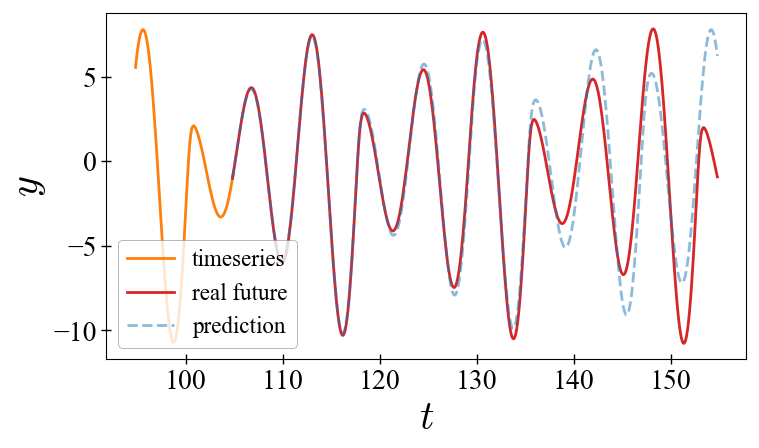

Prediction of 500 points from 1000 points. i.c.: [0.065081, 0.917503, 0.300242]


In [28]:
figure(figsize=(8,4))
past = 100
plot(timevec[N_train-past:N_train+1], s[N_train-past:N_train+1], color = "C1", label = "timeseries")
plot(timevec[N_train:N_train+p], s[N_train:N_train+p], color = "C3", label = "real future")
plot(timevec[N_train:N_train+p], s_pred, color = "C0", linestyle = "dashed", alpha = 0.5, label = "prediction")
legend(); xlabel("\$t\$"); ylabel("\$y\$")
println("Prediction of $(p) points from $(N_train) points. i.c.: $(get_state(ross))")

Of course the prediction depends strongly on:

* Choosing proper `reconstruction` parameters
* The initial condition

How did I know that the value of `τ=17` was good?

In [9]:
estimate_delay(s, "first_zero")

17

The function `localmodel_tsp` also accepts some keyword arguments which I did not discuss. These are:

  * `method = AverageLocalModel()` : Subtype of [`AbstractLocalModel`].
  * `ntype = FixedMassNeighborhood(2)` : Subtype of [`AbstractNeighborhood`].
  * `stepsize = 1` : Prediction step size.
  
We already know what does the `ntype` keyword does: it chooses a neighborhood type. For the other parameters please see the documentation string.

In [10]:
using BenchmarkTools
@btime localmodel_tsp($s_train, $D, $τ, $p)
println("Time for predicting $(p) points from $(N_train) points.")

  689.493 μs (7823 allocations: 568.61 KiB)
Time for predicting 500 points from 1000 points.


Let's bundle all the production-prediction-plotting process into one function and play around!

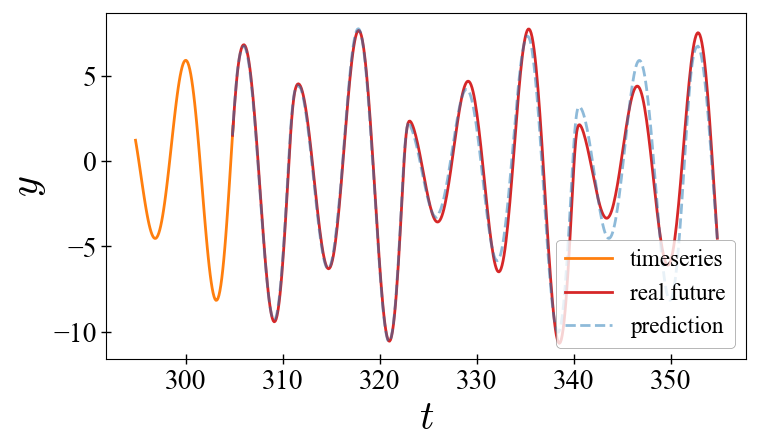

N_train = 3000, p = 500, method = LinearLocalModel, u0 = [0.755493, 0.874031, 0.711756]


In [15]:
function predict_roessler(N_train, p, method, u0 = rand(3); ntype = FixedMassNeighborhood(5))
    
    ds = Systems.roessler(u0)
    dt = 0.1
    tr = trajectory(ds, (N_train+p)÷dt; dt = dt)
    
    s = tr[:, 2] # actually, any of the 3 variables of the Roessler work well
    
    s_train = s[1:N_train]
    s_test = s[N_train+1:end]

    # parameters to predict:
    τ = 17
    D = 3

    s_pred = localmodel_tsp(s_train, D, τ, p; method = method, ntype = ntype)
    
    figure(figsize=(8,4))
    past = 100
    plot(timevec[N_train-past:N_train+1], s[N_train-past:N_train+1], color = "C1", label = "timeseries")
    plot(timevec[N_train:N_train+p], s[N_train:N_train+p], color = "C3", label = "real future")
    plot(timevec[N_train:N_train+p], s_pred, color = "C0", linestyle = "dashed", alpha = 0.5, label = "prediction")
    legend(); xlabel("\$t\$"); ylabel("\$y\$")   
    mprint = nameof(typeof(method))
    println("N_train = $(N_train), p = $(p), method = $(mprint), u0 = $(u0)")
    return
end

predict_roessler(3000, 500, LinearLocalModel(5.0))
# Linear Local model is slower than Average local model, and in general not that
# much more powerful.

# Multi-Variate Prediction

On purpose I was always referring to `s` as "timeseries". There is no reason for `s` to be scalar though, this prediction method works just as well when predicting multiple timeseries. And the call signature does not change at all!

The following example demonstrates the prediction of the Lorenz96 model

$$
\frac{dx_i}{dt} = (x_{i+1}-x_{i-2})x_{i-1} - x_i + F 
$$

a system that displays high-dimensional chaos and is thus very difficult to predict!

Delay time estimation: 9


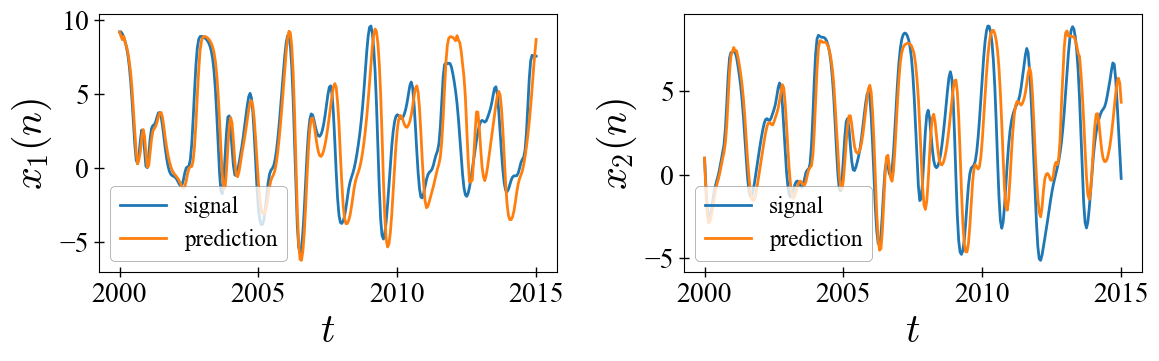

Prediction p=300 of Lorenz96 Model (5 Nodes) from 40000 points
i.c.: [0.54746, 0.87149, 0.539739, 0.860847, 0.743716]


In [17]:
using DynamicalSystems, PyPlot

#Generate timeseries set
ds = Systems.lorenz96(5; F=8.)
ic = get_state(ds)
Δt = 0.05
s = trajectory(ds, 2100; dt=Δt)[:,1:2]

#Set Training and Test Set
N_train = 40000
p = 300
s_train = s[1:N_train,1:2]
s_test  = s[N_train:N_train+p,1:2]

#Embedding Parameters
D = 5; # total dimension of reconstruction is D*2 ! ! !
x = s[:, 1]
τ = estimate_delay(x, "first_zero")
println("Delay time estimation: $(τ)")

#Prediction
method = LinearLocalModel(2.5)
ntype = FixedMassNeighborhood(5)
s_pred  = localmodel_tsp(s_train, D, τ, p; method = method, ntype = ntype)


figure(figsize=(12,4))
ax = subplot(121)
plot((N_train:N_train+p)*Δt, s_test[:,1], label="signal")
plot((N_train:N_train+p)*Δt, s_pred[:,1], label="prediction")
ylabel("\$x_1(n)\$")
xlabel("\$t\$")
legend()
ax = subplot(122)
plot((N_train:N_train+p)*Δt, s_test[:,2], label="signal")
plot((N_train:N_train+p)*Δt, s_pred[:,2], label="prediction")
ylabel("\$x_2(n)\$")
xlabel("\$t\$")
legend()
tight_layout();
println("Prediction p=$p of Lorenz96 Model (5 Nodes) from $N_train points")
println("i.c.: $ic")